In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import auc, precision_recall_curve

pd.set_option('display.max_columns', None)

Reading in prepared data

In [3]:
train_college_imp = pd.read_csv('./train_college_imp.csv')

test_college_imp = pd.read_csv('./test_college_imp.csv')

In [4]:
def drop_stuff(df, l):
    #function drops elements of dataframe
    for i in l:
        df.drop(i, axis = 1, inplace = True)
    return df

In [5]:
#subsetting those that graduated from a 4yr college and those that did not in train set.  
imp_coll_4yr_train = train_college_imp[(train_college_imp.graduated_Y == 1) & (train_college_imp.ps_level == 1)]
imp_not_coll_train = train_college_imp[(train_college_imp.graduated_Y != 1) | (train_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_train['target'] = 1
imp_not_coll_train['target'] = 0

#list of features to drop that will corrupt modelling
drop_list_2 = ['ps_level','wages_cont', 'graduated_Y','Unnamed: 0']

#dropping features
drop_stuff(imp_coll_4yr_train,drop_list_2)
drop_stuff(imp_not_coll_train,drop_list_2)

#rejoining features of training dataset
imp_training = pd.concat([imp_coll_4yr_train,imp_not_coll_train])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [6]:
#subsetting those that graduated from a 4yr college and those that did not in test set.  
imp_coll_4yr_test = test_college_imp[(test_college_imp.graduated_Y == 1)&(test_college_imp.ps_level == 1)]
imp_not_coll_test = test_college_imp[(test_college_imp.graduated_Y != 1)|(test_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_test['target'] = 1
imp_not_coll_test['target'] = 0

#dropping features from test set that would corrupt modelling
drop_stuff(imp_coll_4yr_test, drop_list_2)
drop_stuff(imp_not_coll_test, drop_list_2)

#rejoining features of training dataset
imp_testing = pd.concat([imp_coll_4yr_test,imp_not_coll_test])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [7]:
imp_training.head()

literacy_home  risk_factors  math_b  reading_b  math_conf_b  \
0              3             1   64.65      65.70       0.8689   
1              3             0   63.74      64.71       0.3600   
2              2             0   40.50      46.23      -0.1830   
8              2             0   52.83      60.64      -0.3810   
9              3             0   48.74      55.96      -0.8690   

   verbal_confidence  writing  sports  by_xcurr  homework  hedonics_b  \
0             0.8778    0.052       0         1        10           1   
1             0.6660    1.001       2         2        27           5   
2             0.0780   -0.137       2         0        11           2   
8             1.5960    1.001       2         1         4           1   
9             0.7040    1.001       3         2         9           8   

   hours_working_b  edu_confidence  math_1  math_status_1  hs_gpa  f1_xcurr  \
0                0               7   65.65              6       3         3   
1                0               7   60.59              5       3         1   
2                0               6   42.39              5       2         0   
8                0               6   58.44              5       4         0   
9                0               6   50.38              6       5         4   

   hours_working_1  hedonics_1  math_conf_1  hs_ac_load  effort  testing  \
0                1           1         32.0           6    16.0      196   
1                1           1         24.0           6    33.0      189   
2                3           0         24.0           4    15.0      129   
8                1           1         23.0           3     7.0      172   
9                4           1         24.0           6    14.5      155   

   v_facility  m_facility  academic_p  iq_by_concientiousness  delinquency  \
0      262.80      393.90          48               10507.200       0.5302   
1      258.84      302.95          99               18539.070       2.0168   
2      138.69      211.95          30                5259.600       0.0000   
8      181.92      292.20          28                3318.840       0.0000   
9      223.84      302.28          25                7727.037       0.0000   

   aspired_occ_b_-1  aspired_occ_b_1  aspired_occ_b_2  aspired_occ_b_3  \
0                 0                0                0                0   
1                 0                0                0                0   
2                 1                0                0                0   
8                 0                0                0                0   
9                 0                0                0                0   

   aspired_occ_b_4  aspired_occ_b_5  aspired_occ_b_6  aspired_occ_b_7  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
8                0                0                0                0   
9                0                0                0                0   

   aspired_occ_b_8  aspired_occ_b_9  aspired_occ_b_10  aspired_occ_b_11  \
0                0                0                 1                 0   
1                0                1                 0                 0   
2                0                0                 0                 0   
8                0                0                 1                 0   
9                0                0                 0                 0   

   aspired_occ_b_12  aspired_occ_b_13  aspired_occ_b_14  aspired_occ_b_15  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
8                 0                 0                 0                 0   
9                 0                 0         

with the addition of the 'target', one last bit of exploratory visualization

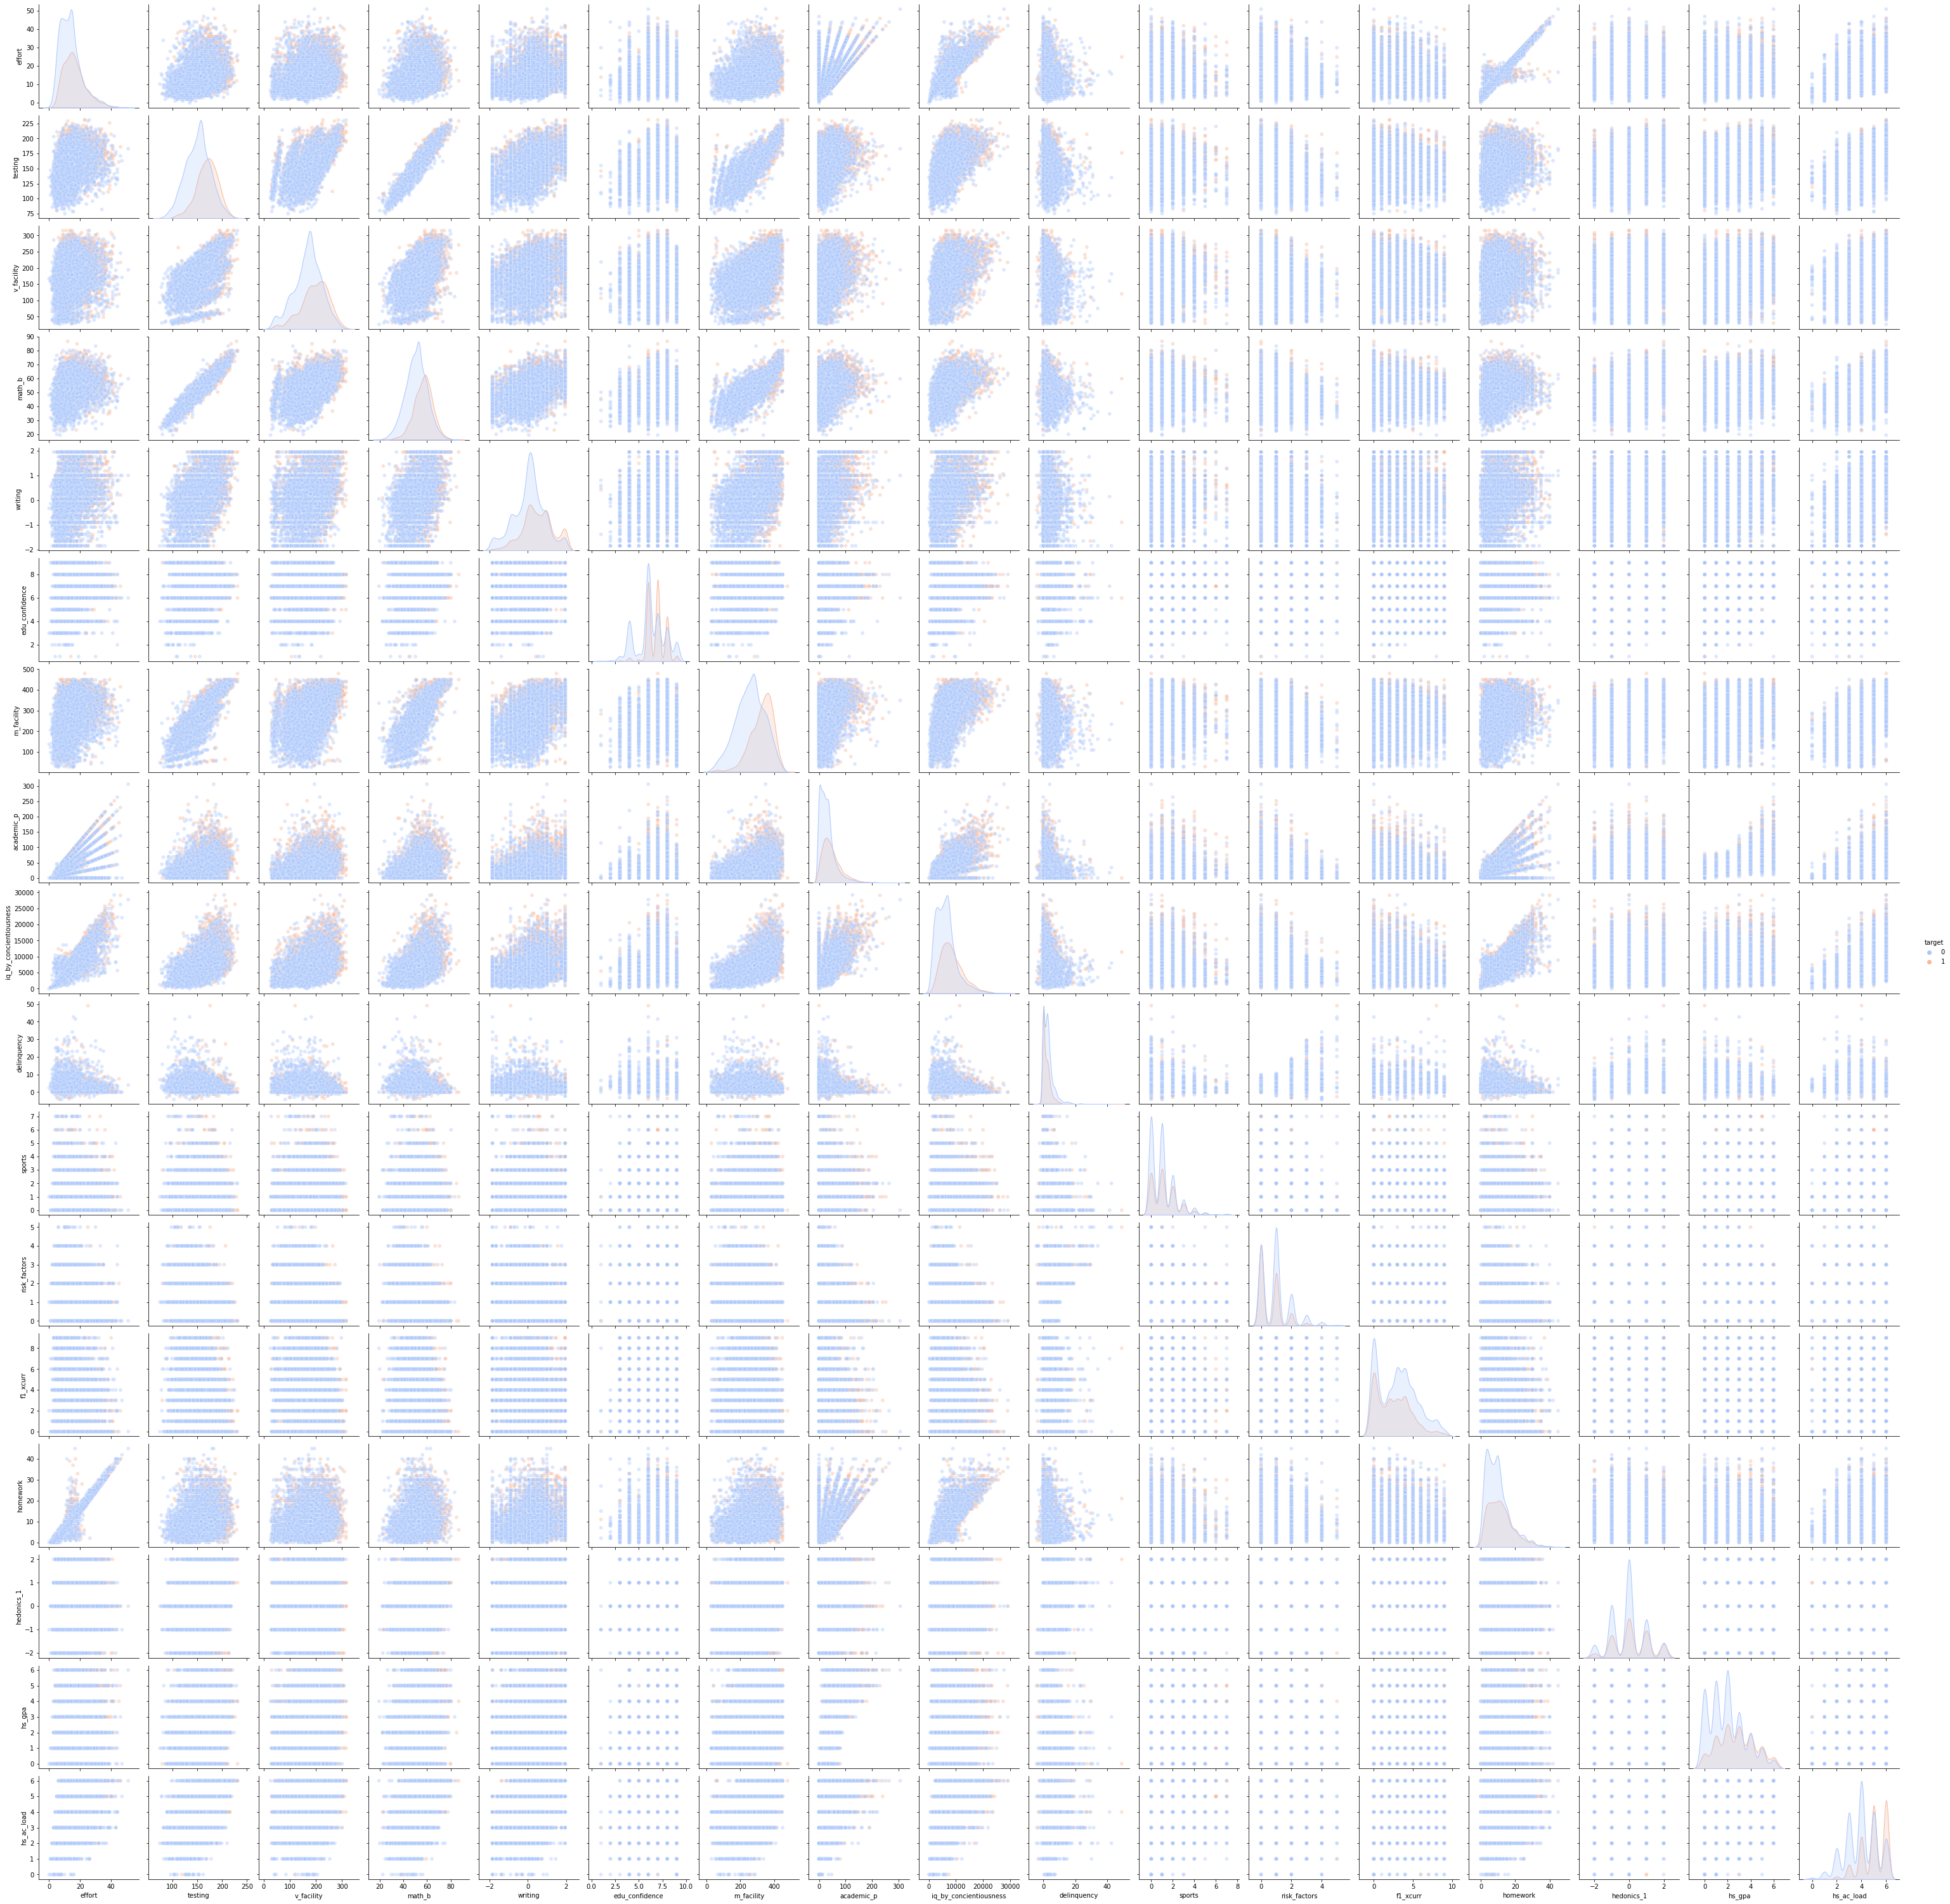

In [8]:
imp_features = imp_training[[ 'target','effort', 'testing', 'v_facility','math_b','writing','edu_confidence',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency','sports','risk_factors','f1_xcurr','homework',
                'hedonics_1','hs_gpa','hs_ac_load',]]

sns.pairplot(imp_features, hue = 'target', diag_kind = 'kde', palette= 'coolwarm', plot_kws=dict(alpha = 0.4),
                   diag_kws=dict(shade=True))

Separating target and features in training set.

In [9]:
imp_training_y = imp_training.target
imp_training_x = imp_training.drop(columns = 'target', axis = 1)

Separating target and features in test set

In [10]:
imp_testing_y = imp_testing.target
imp_testing_x = imp_testing.drop(columns = 'target')

Looking at class imbalance. Class imbalance is not severe enough to warrant upsampling.

In [11]:
print(f'decimal fraction of positive and negative target for training set: \n{imp_training.target.value_counts(normalize = True)}')
print(f'decimal fraction of positive and negative target for testing set: \n{imp_testing.target.value_counts(normalize = True)}')


decimal fraction of positive and negative target for training set: 
0    0.627525
1    0.372475
Name: target, dtype: float64
decimal fraction of positive and negative target for testing set: 
0    0.614336
1    0.385664
Name: target, dtype: float64


Creating a series of training and testing sets with 15, 20 and 25 best features, as well as a set with minimal features, but that will be easy to interpret.

### kbest 15 features

In [12]:
selector = SelectKBest(f_classif, k=15) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb15 = imp_training_x[selected_columns]
X_test_kb15 = imp_testing_x[selected_columns]
print(X_train_kb15.shape, X_test_kb15.shape)

(7920, 15) (1981, 15)


In [13]:
X_test_kb15.columns

Index(['risk_factors', 'math_b', 'reading_b', 'writing', 'edu_confidence',
       'math_1', 'math_status_1', 'hs_gpa', 'hs_ac_load', 'effort', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness'],
      dtype='object')

### k best 20 features

In [14]:
selector = SelectKBest(f_classif, k=20) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb20 = imp_training_x[selected_columns]
X_test_kb20 = imp_testing_x[selected_columns]
print(X_train_kb20.shape, X_test_kb20.shape)

(7920, 20) (1981, 20)


In [15]:
X_train_kb20.columns

Index(['literacy_home', 'risk_factors', 'math_b', 'reading_b', 'math_conf_b',
       'writing', 'by_xcurr', 'edu_confidence', 'math_1', 'math_status_1',
       'hs_gpa', 'math_conf_1', 'hs_ac_load', 'effort', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

### k best 25 features

In [16]:
selector = SelectKBest(f_classif, k=25) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb25 = imp_training_x[selected_columns]
X_test_kb25 = imp_testing_x[selected_columns]
print(X_train_kb25.shape, X_test_kb25.shape)

(7920, 25) (1981, 25)


In [17]:
X_train_kb25.columns

Index(['literacy_home', 'risk_factors', 'math_b', 'reading_b', 'math_conf_b',
       'writing', 'by_xcurr', 'homework', 'hedonics_b', 'edu_confidence',
       'math_1', 'math_status_1', 'hs_gpa', 'hours_working_1', 'hedonics_1',
       'math_conf_1', 'hs_ac_load', 'effort', 'testing', 'v_facility',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency',
       'aspired_occ_1_7'],
      dtype='object')

### Creating a set with features related to academics

In [18]:
keep = ['math_conf_b','writing','edu_confidence',
        'math_conf_1','v_facility','m_facility','academic_p',
       'delinquency','effort','hours_working_1','math_status_1']

x_academics_train = imp_training_x.reindex(keep, axis='columns')
x_academics_test = imp_testing_x.reindex(keep, axis='columns')

### Creating a set with features for lifestyle insight

In [19]:
interpretable = ['testing','academic_p','risk_factors','math_status_1','hedonics_1']

interpretable_x_train = imp_training_x.reindex(interpretable, axis = 'columns')
interpretable_x_test = imp_testing_x.reindex(interpretable, axis = 'columns')

### Creating a set with features scaled using standard scaler.  

In [20]:
scaler = StandardScaler()
scaler.fit(imp_training_x)

X_train_sc = scaler.transform(imp_training_x)
X_test_sc = scaler.transform(imp_testing_x)


In [21]:
X_train_sc.shape

(7920, 64)

### function to print performance metrics of the 

In [22]:
def evaluate(test, pred):    
    #prints four performance metrics
    print('Accuracy: ', round(accuracy_score(test, pred),4))
    print('F1: ', round(f1_score(test, pred),4))
    print('Recall: ', round(recall_score(test, pred),4))
    print('precision: ', round(precision_score(test,pred),4))
    
    #displays confusion matrix
    cm = confusion_matrix(imp_testing_y, pred)
    ConfusionMatrixDisplay(cm).plot()   
    #print(f'confusion matrix: \n {confusion_matrix(imp_testing_y, pred)}')
        
    return 

### function to print ROC curve

In [23]:
def ROC(test_x, model,save = False):
    #prints an ROC curve
    y_pred_prob = model.predict_proba(test_x)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(imp_testing_y, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC curve for {model}')
    plt.xlabel('false positive rate FP/(TN+TP) ')
    plt.ylabel('true positive rate TP/(TP +FN)')
    plt.grid(True)
    if save == True:
        plt.savefig('roclr.png', bbox_inches='tight')
    return

In [24]:
print(imp_training_x.shape)
print(imp_testing_x.shape)

(7920, 64)
(1981, 64)


# Modeling
## Random forest 

random forest with most inclusive training set

Accuracy:  0.6916
F1:  0.5852
Recall:  0.5641
precision:  0.6079


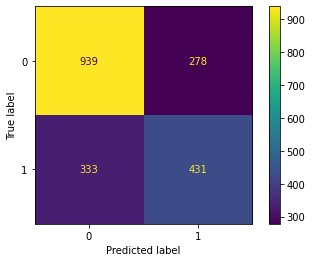

In [25]:
rf = RandomForestClassifier()
rf.fit(imp_training_x, imp_training_y)

predicted_rf = rf.predict(imp_testing_x)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

random forest with 25 kbest

Accuracy:  0.6936
F1:  0.5967
Recall:  0.5877
precision:  0.6059


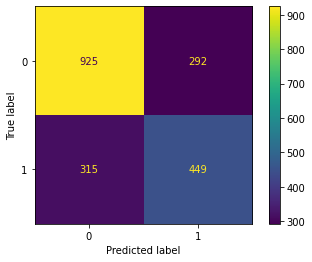

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

random forest with 20 kbest

Accuracy:  0.6901
F1:  0.5885
Recall:  0.5746
precision:  0.603


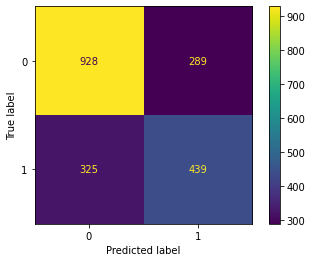

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

In [28]:
#ROC(X_test_kb20,rf)

random forest with 15 kbest

Accuracy:  0.689
F1:  0.5915
Recall:  0.5838
precision:  0.5995


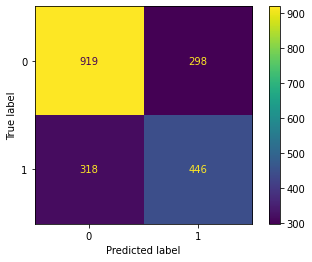

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train_kb15, imp_training_y)

predicted_rf = rf.predict(X_test_kb15)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)  


Accuracy:  0.6461
F1:  0.5222
Recall:  0.5013
precision:  0.5448


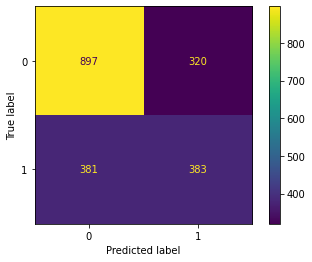

In [30]:
rf = RandomForestClassifier()
rf.fit(interpretable_x_train, imp_training_y)

predicted_rf = rf.predict(interpretable_x_test)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)  


Accuracy:  0.6875
F1:  0.5786
Recall:  0.5563
precision:  0.6028


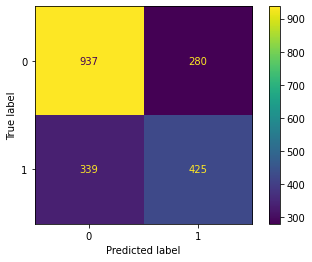

In [31]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, imp_training_y)

predicted_rf = rf.predict(X_test_sc)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

### Tuning random forest

In [32]:
# n_estimators = [int(x) for x in range(90, 120, 10)]
# max_features = ['auto']
# max_depth = [2,3]
# min_samples_split = [2,5]
# min_samples_leaf = [1,2]
# bootstrap = [True]

In [33]:
param_grid_rf = {
    'n_estimators':[140],
    'max_features':['auto'],
    'max_depth':[8],
    'min_samples_split':[4],
    'min_samples_leaf':[1],
    'bootstrap':[False,True],
}

In [34]:
rf = RandomForestClassifier(random_state=13)

In [35]:
clf_rf = GridSearchCV(rf, param_grid_rf,return_train_score = True)
clf_rf.fit(X_train_kb15,imp_training_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=13),
             param_grid={'bootstrap': [False, True], 'max_depth': [8],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [4], 'n_estimators': [140]},
             return_train_score=True)

In [36]:
train_score = np.mean(clf_rf.cv_results_['mean_train_score'])
test_score = clf_rf.score(X_test_kb15, imp_testing_y)
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 140}

Accuracy:  0.6946
F1:  0.6109
Recall:  0.6217
precision:  0.6005


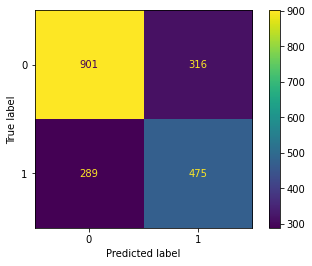

In [37]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb15, imp_training_y)

predicted_rf = rf.predict(X_test_kb15)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

Accuracy:  0.6986
F1:  0.6111
Recall:  0.6139
precision:  0.6083


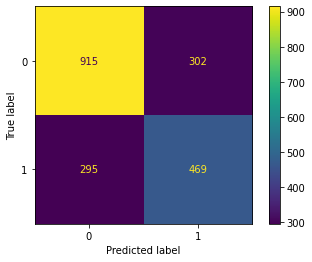

In [38]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

Accuracy:  0.6956
F1:  0.6077
Recall:  0.6113
precision:  0.6041


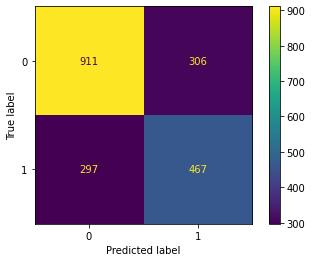

In [39]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(x_academics_train, imp_training_y)

predicted_rf = rf.predict(x_academics_test)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

### random forest with interpretability maximized set

In [40]:
interpretable_x_train.columns

Index(['testing', 'academic_p', 'risk_factors', 'math_status_1', 'hedonics_1'], dtype='object')

Accuracy:  0.6926
F1:  0.598
Recall:  0.5929
precision:  0.6032


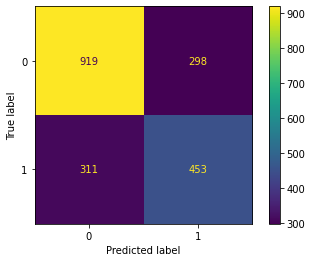

In [41]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(interpretable_x_train, imp_training_y)

predicted_rf = rf.predict(interpretable_x_test)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

### best random forest

Accuracy:  0.7012
F1:  0.6166
Recall:  0.623
precision:  0.6103


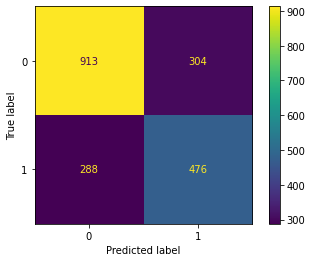

In [42]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

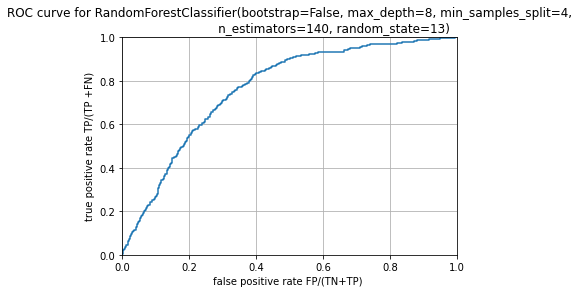

In [43]:
ROC(X_test_kb25, rf)

### logistic regression

Accuracy:  0.6971
F1:  0.5896
Recall:  0.5641
precision:  0.6175


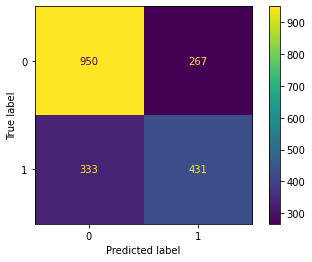

In [44]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(imp_training_x, imp_training_y)

predict_lr = lr.predict(imp_testing_x)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)



Accuracy:  0.6936
F1:  0.5811
Recall:  0.551
precision:  0.6146


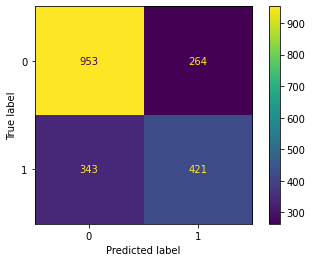

In [45]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb25, imp_training_y)

predict_lr = lr.predict(X_test_kb25)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


Accuracy:  0.683
F1:  0.5489
Recall:  0.5
precision:  0.6083


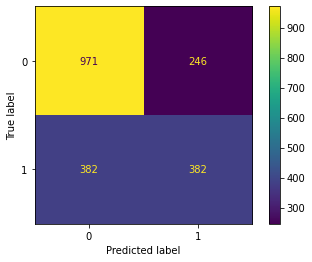

In [46]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(x_academics_train, imp_training_y)

predict_lr = lr.predict(x_academics_test)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)


### Tuning logistic regression

In [47]:
lr = LogisticRegression(solver='liblinear', random_state=13)

param_grid = {    
    'penalty':['l1','l2'],
    'random_state':[13],
    'C':[1],
    'solver' :['liblinear'], 
    'max_iter':[150,175,200]    
}

In [48]:
clf_lr = GridSearchCV(lr, param_grid, return_train_score = True)
clf_lr.fit(X_train_kb20, imp_training_y)

GridSearchCV(estimator=LogisticRegression(random_state=13, solver='liblinear'),
             param_grid={'C': [1], 'max_iter': [150, 175, 200],
                         'penalty': ['l1', 'l2'], 'random_state': [13],
                         'solver': ['liblinear']},
             return_train_score=True)

In [49]:
train_score = np.mean(clf_lr.cv_results_['mean_train_score'])
test_score = clf_lr.score(X_test_kb20, imp_testing_y)
clf_lr.best_params_

{'C': 1,
 'max_iter': 150,
 'penalty': 'l1',
 'random_state': 13,
 'solver': 'liblinear'}

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.7007
F1:  0.5947
Recall:  0.5694
precision:  0.6223


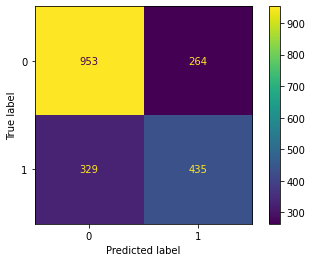

In [50]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 150,random_state=13, C=1,)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

max_iter at '150' throws 'failed to converge' warnings so switching to '175' even though gridsearch recommends '150'

Accuracy:  0.7007
F1:  0.5947
Recall:  0.5694
precision:  0.6223


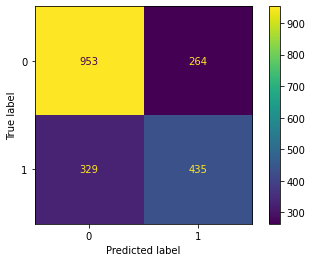

In [51]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

Accuracy:  0.6835
F1:  0.5512
Recall:  0.5039
precision:  0.6082


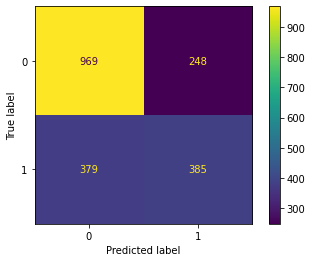

In [52]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(x_academics_train, imp_training_y)

predict_lr = lr.predict(x_academics_test)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

Accuracy:  0.6744
F1:  0.5316
Recall:  0.4791
precision:  0.5971


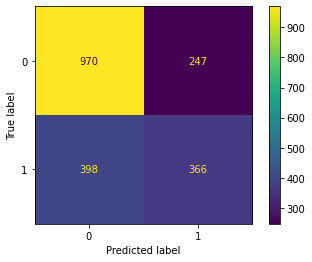

In [53]:
interpretable_x_train
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(interpretable_x_train, imp_training_y)

predict_lr = lr.predict(interpretable_x_test)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

Accuracy:  0.7007
F1:  0.5947
Recall:  0.5694
precision:  0.6223


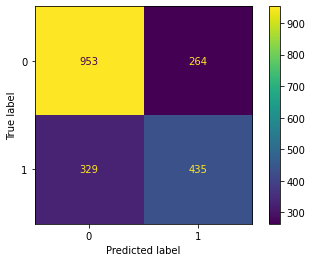

In [54]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

kbest_15 produces best model

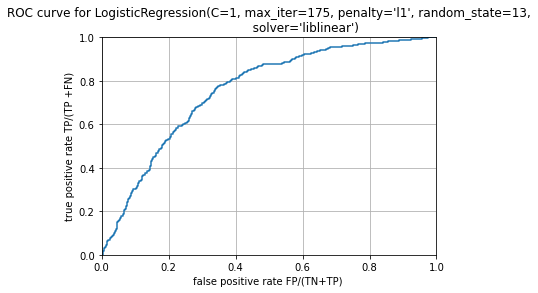

In [55]:
ROC(X_test_kb15,lr)

### XGBoost

xgboost with most inclusive set

Accuracy:  0.6966
F1:  0.615
Recall:  0.6283
precision:  0.6023


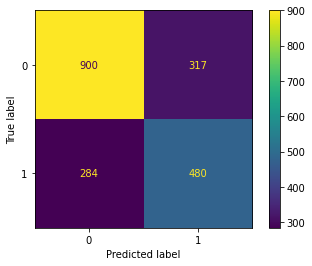

In [56]:
xgb = XGBClassifier()
xgb.fit(imp_training_x,imp_training_y)

predict_xgb = xgb.predict(imp_testing_x)
 
evaluate(imp_testing_y,predict_xgb)

xgboost with 25 kbest

Accuracy:  0.7002
F1:  0.6192
Recall:  0.6322
precision:  0.6068


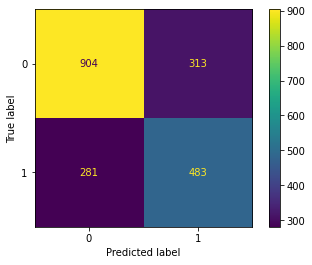

In [57]:
xgb = XGBClassifier()
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

slight performance improvement with more restricted dataset

xgboost with 20 kbest

Accuracy:  0.6921
F1:  0.6085
Recall:  0.6204
precision:  0.597


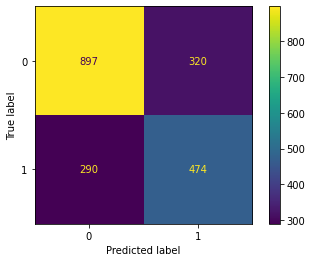

In [58]:
xgb = XGBClassifier()
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

xgboost with 15 kbest.  oddly enough slight improvment in performance with more restricted data set.  

Accuracy:  0.7002
F1:  0.6207
Recall:  0.6361
precision:  0.606


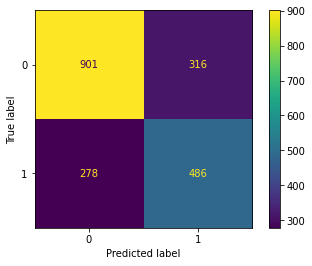

In [59]:
xgb = XGBClassifier()
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

xgboost with set trimmed for academic relevance

Accuracy:  0.689
F1:  0.601
Recall:  0.6073
precision:  0.5949


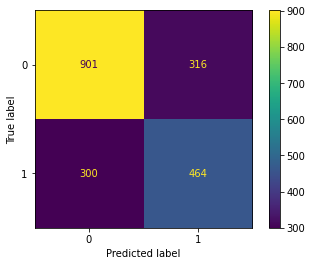

In [60]:
xgb = XGBClassifier()
xgb.fit(x_academics_train,imp_training_y)

predict_xgb = xgb.predict(x_academics_test)
 
evaluate(imp_testing_y,predict_xgb)

xgboost with scaled training set

Accuracy:  0.6966
F1:  0.615
Recall:  0.6283
precision:  0.6023


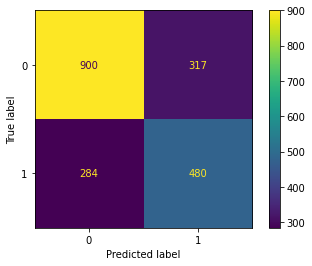

In [61]:
xgb = XGBClassifier()
xgb.fit(X_train_sc,imp_training_y)

predict_xgb = xgb.predict(X_test_sc)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.6845
F1:  0.5902
Recall:  0.589
precision:  0.5913


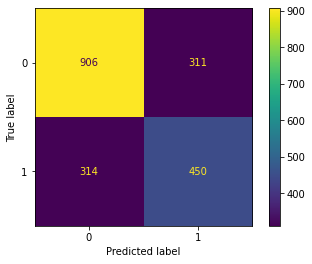

In [62]:
xgb = XGBClassifier()
xgb.fit(interpretable_x_train,imp_training_y)

predict_xgb = xgb.predict(interpretable_x_test)
 
evaluate(imp_testing_y,predict_xgb)

### xgboost tuning

In [63]:
# param_grid_xgb = {
#     "n_estimators"     : [110,130,150],
#     'subsample'        : [.7,.8,.9],
#     "learning_rate"    : [.1,.2,.3] ,
#     "max_depth"        : [2,3,4,5],
#     "min_child_weight" : [3,4,5,6],
#     "gamma"            : [0.1,.15,.2],
#     "colsample_bytree" : [0.6,.7] 
#     }

started with the above parameter and pruned to these

In [64]:
param_grid_xgb = {
    "n_estimators"     : [110,130,150],
    'subsample'        : [.9],
    "learning_rate"    : [.1] ,
    "max_depth"        : [3],
    "min_child_weight" : [5],
    "gamma"            : [0.1,],
    "colsample_bytree" : [0.6] 
    }

In [65]:
clf_xgb = GridSearchCV(xgb, param_grid_xgb,return_train_score = True)
clf_xgb.fit(X_train_kb15,imp_training_y)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.6], 'gamma': [0.1],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'min_child_weight': [5],
                         'n_estimators': [110, 130, 150], 'subsample': [0.9]},
             return_train_score=True)

In [66]:
train_score = np.mean(clf_xgb.cv_results_['mean_train_score'])
test_score = clf_xgb.score(X_test_kb15, imp_testing_y)
clf_xgb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 110,
 'subsample': 0.9}

Accuracy:  0.6956
F1:  0.6147
Recall:  0.6296
precision:  0.6005


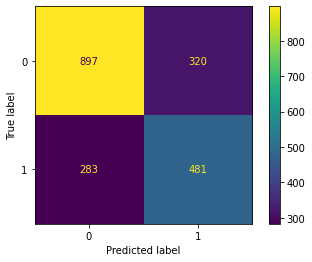

In [67]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 110, gamma = .1,
                    subsample = .9, colsample_bytree = .6,)
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

slight loss in performance on accuracy but gain in other metrics with kbest15 after tuning.

Accuracy:  0.6956
F1:  0.6157
Recall:  0.6322
precision:  0.6


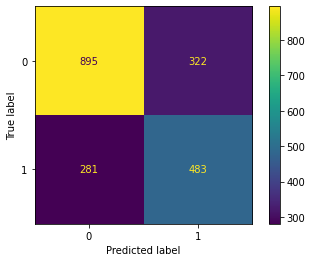

In [68]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 110, gamma = .1, subsample = .9, colsample_bytree = .6,)
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.6926
F1:  0.6053
Recall:  0.6113
precision:  0.5995


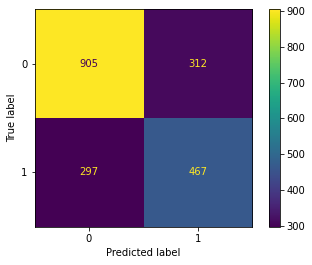

In [70]:
xgb = XGBClassifier(subsample = .9, colsample_bytree = .5,)
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.682
F1:  0.5888
Recall:  0.5903
precision:  0.5872


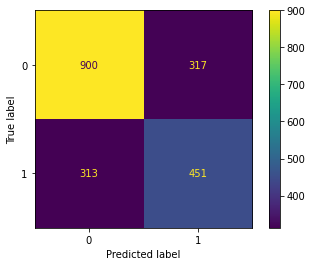

In [71]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 110, gamma = .1, subsample = .9, colsample_bytree = .6,)
xgb.fit(x_academics_train,imp_training_y)

predict_xgb = xgb.predict(x_academics_test)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.6941
F1:  0.609
Recall:  0.6178
precision:  0.6005


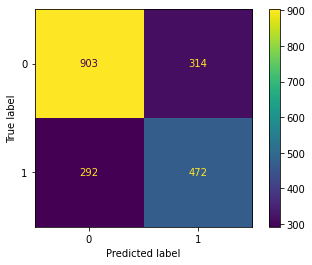

In [72]:
xgb = XGBClassifier(subsample = .9, colsample_bytree = .5,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.7007
F1:  0.624
Recall:  0.644
precision:  0.6052


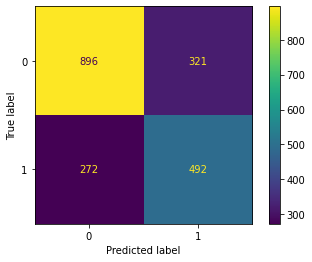

In [73]:
xgb = XGBClassifier(subsample = .9, colsample_bytree = .5,)
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.6951
F1:  0.6113
Recall:  0.6217
precision:  0.6013


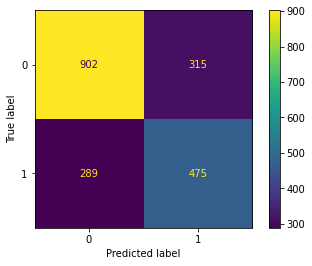

In [74]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 100, gamma = .3, subsample = .9,
                    learning_rate = .1, min_child_weight = 3, colsample_bytree = .6)
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.7012
F1:  0.6229
Recall:  0.6401
precision:  0.6067


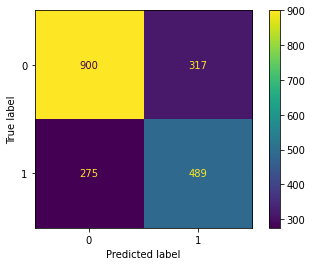

In [75]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 100, gamma = .3, subsample = .9,
                    learning_rate = .1, min_child_weight = 3, colsample_bytree = .6)
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

Accuracy:  0.7047
F1:  0.6199
Recall:  0.6243
precision:  0.6155


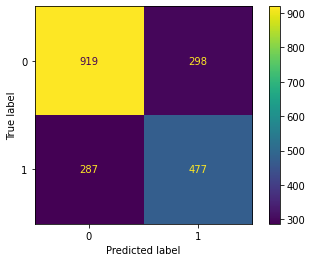

In [76]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 100, gamma = .3, subsample = .9,
                    learning_rate = .1, min_child_weight = 3, colsample_bytree = .6)
xgb.fit(imp_training_x,imp_training_y)

predict_xgb = xgb.predict(imp_testing_x)
 
evaluate(imp_testing_y,predict_xgb)

this was the best performance with xgboost even though used most inclusive dataset.

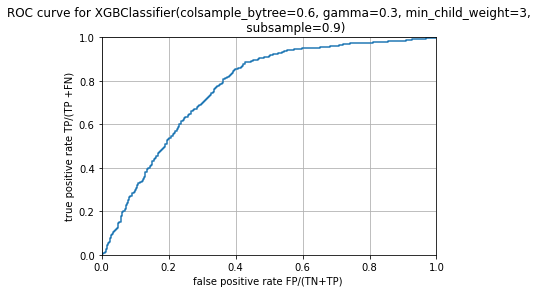

In [77]:
ROC(imp_testing_x,xgb)

Accuracy:  0.689
F1:  0.5926
Recall:  0.5864
precision:  0.5989


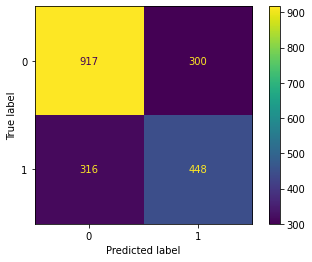

In [78]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 100, gamma = .3, subsample = .9,
                    learning_rate = .1, min_child_weight = 3, colsample_bytree = .6)
xgb.fit(interpretable_x_train,imp_training_y)

predict_xgb = xgb.predict(interpretable_x_test)
 
evaluate(imp_testing_y,predict_xgb)

### gaussian naive bayes

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


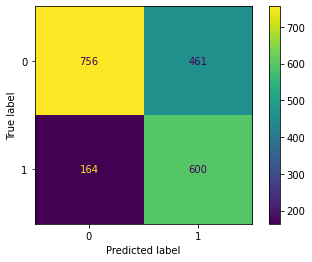

In [79]:
gnb = GaussianNB()

gnb.fit(imp_training_x,imp_training_y)

predict_gnb = gnb.predict(imp_testing_x)

evaluate(imp_testing_y,predict_gnb)

best recall and no movement from different datasets

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


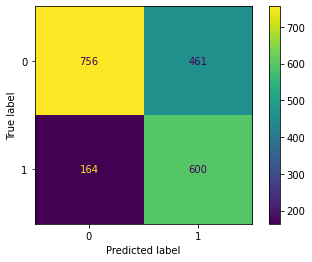

In [80]:
gnb = GaussianNB()

gnb.fit(X_train_kb25,imp_training_y)

predict_nb = gnb.predict(X_test_kb25)

evaluate(imp_testing_y,predict_gnb)

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


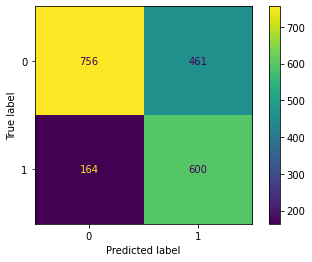

In [81]:
gnb = GaussianNB()

gnb.fit(X_train_kb20,imp_training_y)

predict_nb = gnb.predict(X_test_kb20)

evaluate(imp_testing_y,predict_gnb)

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


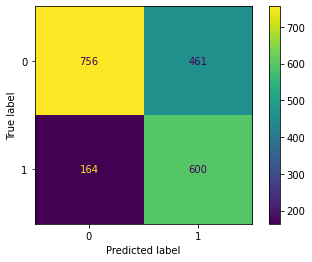

In [82]:
gnb = GaussianNB()

gnb.fit(X_train_kb15,imp_training_y)

predict_nb = gnb.predict(X_test_kb15)

evaluate(imp_testing_y,predict_gnb)

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


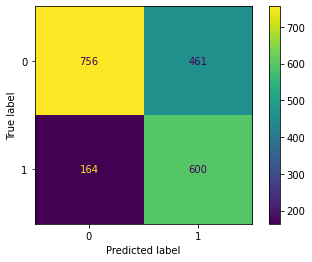

In [83]:
gnb = GaussianNB()

gnb.fit(x_academics_train,imp_training_y)

predict_nb = gnb.predict(x_academics_test)

evaluate(imp_testing_y,predict_gnb)

In [84]:
interpretable_x_train.shape

(7920, 5)

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


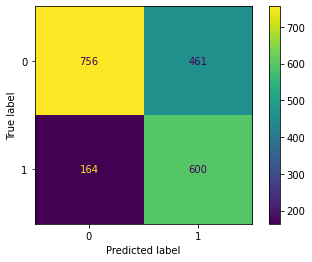

In [85]:
gnb = GaussianNB()

gnb.fit(interpretable_x_train,imp_training_y)

predict_nb = gnb.predict(interpretable_x_test)

evaluate(imp_testing_y,predict_gnb)

#ROC(x_trimmed_train,gnb)

Accuracy:  0.6845
F1:  0.6575
Recall:  0.7853
precision:  0.5655


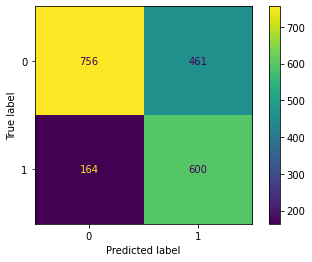

In [86]:
gnb = GaussianNB()

gnb.fit(X_train_sc,imp_training_y)

predict_nb = gnb.predict(X_test_sc)

evaluate(imp_testing_y,predict_gnb)

### KNN

Accuracy:  0.6345
F1:  0.5061
Recall:  0.4856
precision:  0.5285


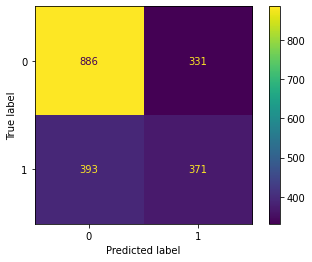

In [87]:
knn = KNeighborsClassifier()

knn.fit(imp_training_x,imp_training_y)

predict_knn = knn.predict(imp_testing_x)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.635
F1:  0.5072
Recall:  0.4869
precision:  0.5292


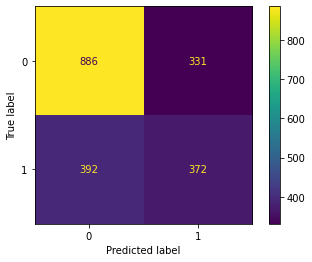

In [88]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb25,imp_training_y)

predict_knn = knn.predict(X_test_kb25)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.6376
F1:  0.5089
Recall:  0.4869
precision:  0.533


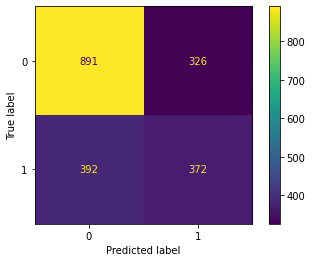

In [89]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb20,imp_training_y)

predict_knn = knn.predict(X_test_kb20)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.6376
F1:  0.5096
Recall:  0.4882
precision:  0.5329


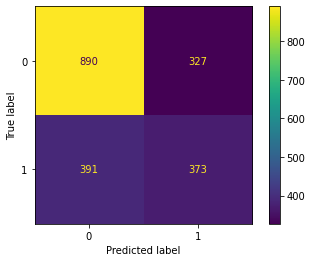

In [90]:
knn = KNeighborsClassifier()

knn.fit(X_train_kb15,imp_training_y)

predict_knn = knn.predict(X_test_kb15)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.6552
F1:  0.5663
Recall:  0.5838
precision:  0.5499


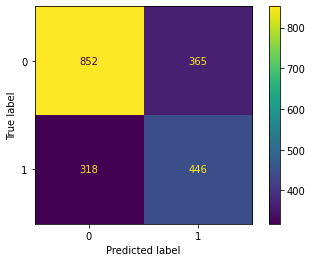

In [91]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.6512
F1:  0.5396
Recall:  0.5301
precision:  0.5495


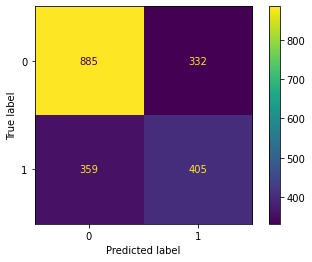

In [92]:
knn = KNeighborsClassifier()

knn.fit(interpretable_x_train,imp_training_y)

predict_knn = knn.predict(interpretable_x_test)

evaluate(imp_testing_y,predict_knn)

In [93]:
param_grid_knn = {
    'n_neighbors':list(range(50,150,10)), 
    'leaf_size':[1,2,3], 
    "p":[1,2,3],  

    }

In [94]:
clf_knn = GridSearchCV(knn, param_grid_knn, cv = 5)
clf_knn.fit(X_train_kb25, imp_training_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3],
                         'n_neighbors': [50, 60, 70, 80, 90, 100, 110, 120, 130,
                                         140],
                         'p': [1, 2, 3]})

In [95]:
#train_score = np.mean(clf_knn.cv_results_['mean_train_score'])
test_score = clf_knn.score(X_test_kb25, imp_testing_y)
clf_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 60, 'p': 1}

Accuracy:  0.7042
F1:  0.6244
Recall:  0.6374
precision:  0.6118


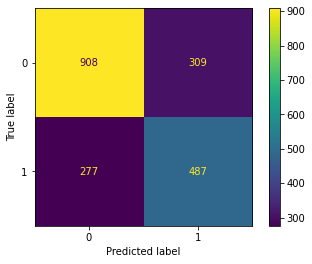

In [96]:
knn = KNeighborsClassifier(n_neighbors = 60, leaf_size = 1, p = 1)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)


scaling gives best performance gain on KNN.  possibly becasue the algorithm relies on distance measures and standard scaling takes noise out of distances

Accuracy:  0.6991
F1:  0.6199
Recall:  0.6361
precision:  0.6045


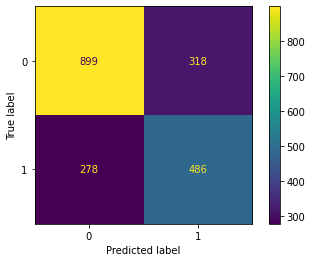

In [97]:
knn = KNeighborsClassifier(n_neighbors = 70, leaf_size = 1, p = 1)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

Accuracy:  0.7022
F1:  0.6164
Recall:  0.6204
precision:  0.6124


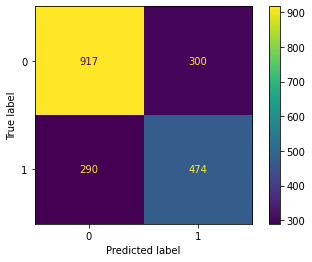

In [98]:
knn = KNeighborsClassifier(n_neighbors = 40, leaf_size = 1, p = 1)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)


Accuracy:  0.7042
F1:  0.6244
Recall:  0.6374
precision:  0.6118


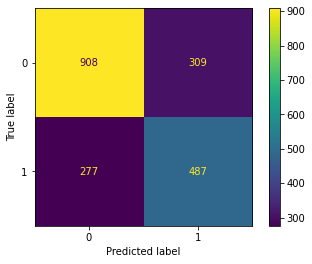

In [99]:
knn = KNeighborsClassifier(n_neighbors = 60, leaf_size = 1,p = 1)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

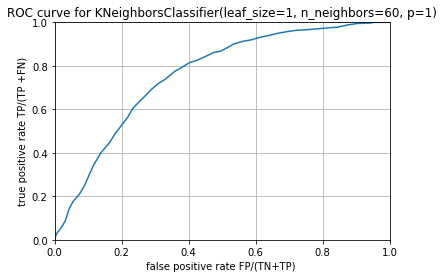

In [100]:
ROC(X_test_sc,knn)

## best models

## random forest

Accuracy:  0.7012
F1:  0.6166
Recall:  0.623
precision:  0.6103


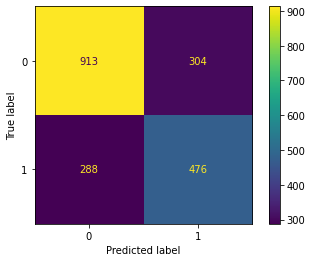

In [101]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)
accuracy_rf = accuracy_score(imp_testing_y, predicted_rf)

evaluate(imp_testing_y,predicted_rf)

In [104]:
probs_rf = rf.predict_proba(X_test_kb25)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

## logistic regression

Accuracy:  0.7007
F1:  0.5947
Recall:  0.5694
precision:  0.6223


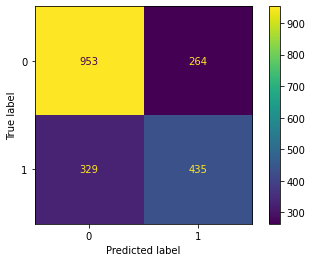

In [105]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)
accuracy_lr = accuracy_score(imp_testing_y, predict_lr)

evaluate(imp_testing_y,predict_lr)

In [106]:
probs_lr = lr.predict_proba(X_test_kb15)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

## XGBoost

Accuracy:  0.7012
F1:  0.6229
Recall:  0.6401
precision:  0.6067


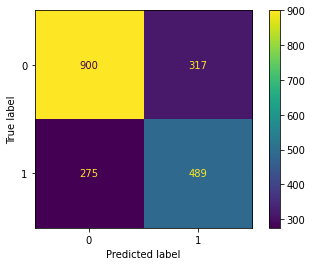

In [107]:
xgb = XGBClassifier(max_depth = 3, n_estimators = 100, gamma = .3, subsample = .9,
                    learning_rate = .1, min_child_weight = 3, colsample_bytree = .6)
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

In [108]:
probs_xgb = xgb.predict_proba(X_test_kb25)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

## gaussian naive bayes

Accuracy:  0.6492
F1:  0.6423
Recall:  0.8168
precision:  0.5293


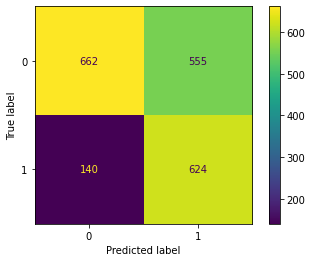

In [109]:
gnb = GaussianNB()

gnb.fit(X_train_sc,imp_training_y)

predict_gnb = gnb.predict(X_test_sc)

evaluate(imp_testing_y,predict_gnb)

In [110]:
probs_gnb= gnb.predict_proba(X_test_sc)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

### KNN

Accuracy:  0.7042
F1:  0.6244
Recall:  0.6374
precision:  0.6118


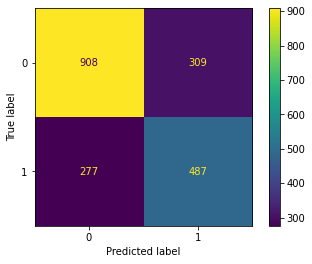

In [111]:
knn = KNeighborsClassifier(n_neighbors = 60, leaf_size = 1,p = 1)

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

In [112]:
probs_knn = knn.predict_proba(X_test_sc)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

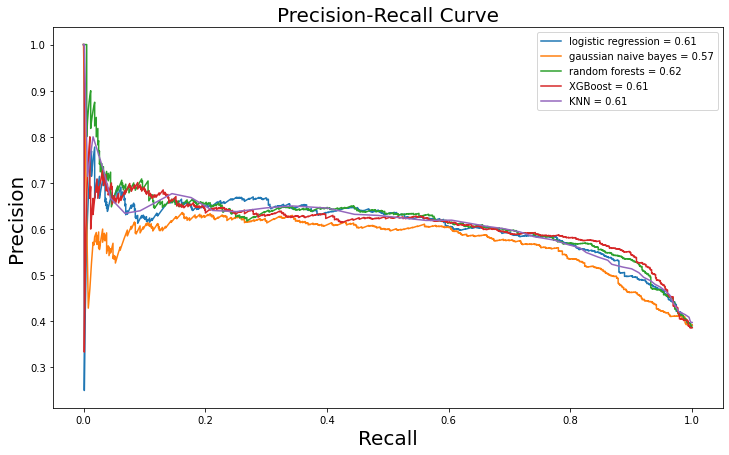

In [113]:
plt.figure(figsize=(12, 7))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();